# Predicting Spotify Playlist Adds 

## Part 3: Machine Learning and Predictive Modeling

This notebook imports the datasets collected in Part 1, preprocesses the features and evaluates various methods to build a predictive model. Specifically, we'll develop a pipeline to predict the susceptability of an unheard song being added to either users' playlist. We'll focus on evaluating the accuraccy of the model and improving it through feature engineering.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

#import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils import resample

from ast import literal_eval

import pickle

#load datasets
user_1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GA Spotify Project/data/user_1.csv', converters={"artist_name": literal_eval, 'artist_id': literal_eval}) # to convert strings back into list
user_2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GA Spotify Project/data/user_2.csv', converters={'artist_name': literal_eval, 'artist_id': literal_eval})
user_1_artist_info = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GA Spotify Project/data/user_1_artist_info.csv', converters={'artist_genre': literal_eval})
user_2_artist_info = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GA Spotify Project/data/user_2_artist_info.csv', converters={'artist_genre': literal_eval})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
user_1.head()

,track_id,track_name,artist_name,artist_id,release_date,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0sR0deixp6xTZ5Yx9g0pr0,Release Me,[Miette Hope],[4K61UysqQc1VRj8VsY76Qw],2018-06-22,single,34,0.517,0.480,11,-7.944,0,0.0425,0.6830,0.000000,0.0760,0.539,134.012,212236,4
1,0doiRAg2YNQvamY6oMPwkw,Dancing in the Street,[Stephen Day],[4cnFw4bkIWVGKUBsr93OS5],2018-04-27,single,4,0.632,0.677,11,-8.105,1,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4
2,0NuIfPuBhUAt4aA4HP0rUu,You Seemed so Happy,[The Japanese House],[3IunaFjvNKj98JW89JYv9u],2019-03-01,album,53,0.519,0.888,11,-6.232,1,0.1170,0.0406,0.000000,0.2270,0.416,149.938,162486,4
3,5EXD5rXJ4IVb8g4xSwT0fc,If You Were the Rain,[Stephen Day],[4cnFw4bkIWVGKUBsr93OS5],2016-04-08,single,47,0.481,0.412,9,-8.413,1,0.0401,0.6110,0.000059,0.0998,0.326,84.358,220588,4
4,68ViVsxqymVrKMnAbVsEhU,Talking Slow,[Dylan Jordan],[0vQwQkQbLxrapE7TG9o5SB],2018-12-12,single,48,0.501,0.533,2,-10.110,1,0.0379,0.2020,0.002060,0.1130,0.151,138.920,259640,4


In [3]:
user_2.head()

,track_id,track_name,artist_name,artist_id,release_date,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,01c9sDv4paB121N6l2BFKY,Babylon,"[Jauz, Tisoki]","[5ttgIeUVka6FLyi00Uu5h8, 0XW7mqhbaQnRtHmwfAVg64]",2018-08-31,album,35,0.611,0.920,1,-3.531,1,0.1440,0.0232,0.00150,0.1470,0.451,145.005,293000,4
1,48iZQ89FuDSmqRk1AjRcrP,OK!,"[Jauz, San Holo]","[5ttgIeUVka6FLyi00Uu5h8, 0jNDKefhfSbLR9sFvcPLHo]",2016-10-10,single,42,0.615,0.885,10,-3.281,0,0.0397,0.0174,0.00422,0.1010,0.112,127.939,188438,4
2,6DlpWCFx1fsv0LCa3AQ81D,Infected,"[Tiësto, Jauz]","[2o5jDhtHVPhrJdv3cEQ99Z, 5ttgIeUVka6FLyi00Uu5h8]",2016-07-15,single,43,0.605,0.974,5,-3.996,0,0.1690,0.0764,0.31200,0.1280,0.082,128.030,225000,4
3,03IxJiB8ZOH9hEQZF5mCNY,Feel The Volume,[Jauz],[5ttgIeUVka6FLyi00Uu5h8],2014-11-11,single,55,0.725,0.918,10,-4.912,0,0.0676,0.1530,0.03280,0.1130,0.201,125.009,230400,4
4,4BNWc6VNhfANsYMeTxGw4R,Get To Me,[Jauz],[5ttgIeUVka6FLyi00Uu5h8],2019-10-11,single,46,0.574,0.899,1,-3.619,1,0.0483,0.3210,0.00000,0.0927,0.387,128.060,256875,4


In [4]:
user_1_artist_info.head()

,artist_id,artist_genre,artist_follower_count
0,4K61UysqQc1VRj8VsY76Qw,[],7547
1,4cnFw4bkIWVGKUBsr93OS5,"[indie cafe pop, indie r&b, indiecoustica]",20710
2,3IunaFjvNKj98JW89JYv9u,"[art pop, electropop, indie pop, indie poptimi...",351533
3,0vQwQkQbLxrapE7TG9o5SB,[],21188
4,5dCvSnVduaFleCnyy98JMo,"[k-indie, k-pop, korean pop, korean r&b]",428238


In [5]:
user_2_artist_info.head()

,artist_id,artist_genre,artist_follower_count
0,5ttgIeUVka6FLyi00Uu5h8,"[bass house, brostep, edm, electro house, elec...",325977
1,0XW7mqhbaQnRtHmwfAVg64,"[brostep, electro house, electronic trap, zaps...",37132
2,0jNDKefhfSbLR9sFvcPLHo,"[edm, electro house, electronic trap, electrop...",550744
3,2o5jDhtHVPhrJdv3cEQ99Z,"[big room, brostep, dance pop, dutch edm, edm,...",4935665
4,548YUkLaLzti0BLqaWpn1W,"[bass house, brostep, electro house, electroni...",43906


### Preparing our data for modeling
Let's begin by concatenating the two datasets, creating an additional column that separates the two users.

In [6]:
user_1['user_group'] = 1
user_2['user_group'] = 0

spotify_df = pd.concat([user_1, user_2])
spotify_df.head()

,track_id,track_name,artist_name,artist_id,release_date,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user_group
0,0sR0deixp6xTZ5Yx9g0pr0,Release Me,[Miette Hope],[4K61UysqQc1VRj8VsY76Qw],2018-06-22,single,34,0.517,0.480,11,-7.944,0,0.0425,0.6830,0.000000,0.0760,0.539,134.012,212236,4,1
1,0doiRAg2YNQvamY6oMPwkw,Dancing in the Street,[Stephen Day],[4cnFw4bkIWVGKUBsr93OS5],2018-04-27,single,4,0.632,0.677,11,-8.105,1,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4,1
2,0NuIfPuBhUAt4aA4HP0rUu,You Seemed so Happy,[The Japanese House],[3IunaFjvNKj98JW89JYv9u],2019-03-01,album,53,0.519,0.888,11,-6.232,1,0.1170,0.0406,0.000000,0.2270,0.416,149.938,162486,4,1
3,5EXD5rXJ4IVb8g4xSwT0fc,If You Were the Rain,[Stephen Day],[4cnFw4bkIWVGKUBsr93OS5],2016-04-08,single,47,0.481,0.412,9,-8.413,1,0.0401,0.6110,0.000059,0.0998,0.326,84.358,220588,4,1
4,68ViVsxqymVrKMnAbVsEhU,Talking Slow,[Dylan Jordan],[0vQwQkQbLxrapE7TG9o5SB],2018-12-12,single,48,0.501,0.533,2,-10.110,1,0.0379,0.2020,0.002060,0.1130,0.151,138.920,259640,4,1


In [7]:
#first of all, track name and id, as well as artist name and id represent the same information
#we can begin by removing those two columns as they'll result in multicollinearity 
remove_lst = ['track_name', 'artist_name']
spotify_col = [col for col in spotify_df.columns.to_list() if col not in remove_lst]
spotify_df = spotify_df[spotify_col]
spotify_df.head()

,track_id,artist_id,release_date,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user_group
0,0sR0deixp6xTZ5Yx9g0pr0,[4K61UysqQc1VRj8VsY76Qw],2018-06-22,single,34,0.517,0.480,11,-7.944,0,0.0425,0.6830,0.000000,0.0760,0.539,134.012,212236,4,1
1,0doiRAg2YNQvamY6oMPwkw,[4cnFw4bkIWVGKUBsr93OS5],2018-04-27,single,4,0.632,0.677,11,-8.105,1,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4,1
2,0NuIfPuBhUAt4aA4HP0rUu,[3IunaFjvNKj98JW89JYv9u],2019-03-01,album,53,0.519,0.888,11,-6.232,1,0.1170,0.0406,0.000000,0.2270,0.416,149.938,162486,4,1
3,5EXD5rXJ4IVb8g4xSwT0fc,[4cnFw4bkIWVGKUBsr93OS5],2016-04-08,single,47,0.481,0.412,9,-8.413,1,0.0401,0.6110,0.000059,0.0998,0.326,84.358,220588,4,1
4,68ViVsxqymVrKMnAbVsEhU,[0vQwQkQbLxrapE7TG9o5SB],2018-12-12,single,48,0.501,0.533,2,-10.110,1,0.0379,0.2020,0.002060,0.1130,0.151,138.920,259640,4,1


In [8]:
spotify_df.shape

(3951, 19)

#### Feature Engineering
To build a prediction model, data must be numeric ==> we should encode all categorical variables


In [0]:
#for the mode, we'll rename the values so that 1 is 'major' and 0 is 'minor' 
#--> this is so that we can one-hot-encode during preprocessing
spotify_df['mode'] = np.where(spotify_df['mode'] == 1, 'Major', "Minor")

In [0]:
#key, mode time_signatures are categorical values, so we'll transform them into strings to one-hot-encode
spotify_df['key'] = spotify_df['key'].astype(str)
spotify_df['time_signature'] = spotify_df['time_signature'].astype(str)

In [0]:
#we should figure out what to do with the release_date as we can't parse date-time objects into a model
#we could separate out year, month and date into individual columns 
spotify_df['release_date'] = pd.to_datetime(spotify_df['release_date'])
spotify_df['release_date_day'] = spotify_df['release_date'].dt.day
spotify_df['release_date_month'] = spotify_df['release_date'].dt.month
spotify_df['release_date_year'] = spotify_df['release_date'].dt.year

#we could also create a column to identify what week and day of the week a track was released
spotify_df['release_date_dayofweek'] = spotify_df['release_date'].dt.dayofweek
spotify_df['release_date_week'] = spotify_df['release_date'].dt.week

#drop the original release_date
spotify_df.drop('release_date', axis=1, inplace=True)

Release date would not usually come into consideration when we listen to music - especially what day of the week a track came out, etc. However, Spotify's playlist curation is greatly influenced by the day of the week a track is released. Specifically, there's a cut-off point to when a track would be considered for editorial/algorithmic playlists; thus, it indirectly influences our music consumption habit.

Month, day, week and dayofweek are categorical variables in ordinal order

In [0]:
#categorical features
categorical_feat = ['track_id', 'artist_id', 'release_date_day', 'release_date_month', 'release_date_year',
                    'release_date_dayofweek', 'release_date_week', 'album_type', 'key', 'mode',
                    'time_signature']
numerical_feat = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


In [13]:
spotify_df.head()

,track_id,artist_id,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user_group,release_date_day,release_date_month,release_date_year,release_date_dayofweek,release_date_week
0,0sR0deixp6xTZ5Yx9g0pr0,[4K61UysqQc1VRj8VsY76Qw],single,34,0.517,0.480,11,-7.944,Minor,0.0425,0.6830,0.000000,0.0760,0.539,134.012,212236,4,1,22,6,2018,4,25
1,0doiRAg2YNQvamY6oMPwkw,[4cnFw4bkIWVGKUBsr93OS5],single,4,0.632,0.677,11,-8.105,Major,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4,1,27,4,2018,4,17
2,0NuIfPuBhUAt4aA4HP0rUu,[3IunaFjvNKj98JW89JYv9u],album,53,0.519,0.888,11,-6.232,Major,0.1170,0.0406,0.000000,0.2270,0.416,149.938,162486,4,1,1,3,2019,4,9
3,5EXD5rXJ4IVb8g4xSwT0fc,[4cnFw4bkIWVGKUBsr93OS5],single,47,0.481,0.412,9,-8.413,Major,0.0401,0.6110,0.000059,0.0998,0.326,84.358,220588,4,1,8,4,2016,4,14
4,68ViVsxqymVrKMnAbVsEhU,[0vQwQkQbLxrapE7TG9o5SB],single,48,0.501,0.533,2,-10.110,Major,0.0379,0.2020,0.002060,0.1130,0.151,138.920,259640,4,1,12,12,2018,2,50


In [14]:
#now, let's unstack the list of artist_ids
#spotify_df['artist_id'] = literal_eval(spotify_df['artist_id'])
spotify_df = spotify_df.explode('artist_id')#.reset_index(drop=True)
spotify_df.head()

,track_id,artist_id,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user_group,release_date_day,release_date_month,release_date_year,release_date_dayofweek,release_date_week
0,0sR0deixp6xTZ5Yx9g0pr0,4K61UysqQc1VRj8VsY76Qw,single,34,0.517,0.480,11,-7.944,Minor,0.0425,0.6830,0.000000,0.0760,0.539,134.012,212236,4,1,22,6,2018,4,25
1,0doiRAg2YNQvamY6oMPwkw,4cnFw4bkIWVGKUBsr93OS5,single,4,0.632,0.677,11,-8.105,Major,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4,1,27,4,2018,4,17
2,0NuIfPuBhUAt4aA4HP0rUu,3IunaFjvNKj98JW89JYv9u,album,53,0.519,0.888,11,-6.232,Major,0.1170,0.0406,0.000000,0.2270,0.416,149.938,162486,4,1,1,3,2019,4,9
3,5EXD5rXJ4IVb8g4xSwT0fc,4cnFw4bkIWVGKUBsr93OS5,single,47,0.481,0.412,9,-8.413,Major,0.0401,0.6110,0.000059,0.0998,0.326,84.358,220588,4,1,8,4,2016,4,14
4,68ViVsxqymVrKMnAbVsEhU,0vQwQkQbLxrapE7TG9o5SB,single,48,0.501,0.533,2,-10.110,Major,0.0379,0.2020,0.002060,0.1130,0.151,138.920,259640,4,1,12,12,2018,2,50


In [15]:
#let's observe the size
spotify_df.shape

(6692, 23)

In [0]:
#merge additional artist info into the dataframe
artist_info = pd.concat([user_1_artist_info, user_2_artist_info])
spotify_df = spotify_df.merge(artist_info, how='left', on='artist_id')

In [17]:
spotify_df.head()

,track_id,artist_id,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user_group,release_date_day,release_date_month,release_date_year,release_date_dayofweek,release_date_week,artist_genre,artist_follower_count
0,0sR0deixp6xTZ5Yx9g0pr0,4K61UysqQc1VRj8VsY76Qw,single,34,0.517,0.480,11,-7.944,Minor,0.0425,0.6830,0.000000,0.0760,0.539,134.012,212236,4,1,22,6,2018,4,25,[],7547
1,0doiRAg2YNQvamY6oMPwkw,4cnFw4bkIWVGKUBsr93OS5,single,4,0.632,0.677,11,-8.105,Major,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4,1,27,4,2018,4,17,"[indie cafe pop, indie r&b, indiecoustica]",20710
2,0NuIfPuBhUAt4aA4HP0rUu,3IunaFjvNKj98JW89JYv9u,album,53,0.519,0.888,11,-6.232,Major,0.1170,0.0406,0.000000,0.2270,0.416,149.938,162486,4,1,1,3,2019,4,9,"[art pop, electropop, indie pop, indie poptimi...",351533
3,5EXD5rXJ4IVb8g4xSwT0fc,4cnFw4bkIWVGKUBsr93OS5,single,47,0.481,0.412,9,-8.413,Major,0.0401,0.6110,0.000059,0.0998,0.326,84.358,220588,4,1,8,4,2016,4,14,"[indie cafe pop, indie r&b, indiecoustica]",20710
4,68ViVsxqymVrKMnAbVsEhU,0vQwQkQbLxrapE7TG9o5SB,single,48,0.501,0.533,2,-10.110,Major,0.0379,0.2020,0.002060,0.1130,0.151,138.920,259640,4,1,12,12,2018,2,50,[],21188


In [18]:
spotify_df.shape

(10057, 25)

In [19]:
#now, we can unstack the list of artist genres, as some artists have multiple genres
spotify_df = spotify_df.explode('artist_genre')#.reset_index(drop=True)
spotify_df

,track_id,artist_id,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,user_group,release_date_day,release_date_month,release_date_year,release_date_dayofweek,release_date_week,artist_genre,artist_follower_count
0,0sR0deixp6xTZ5Yx9g0pr0,4K61UysqQc1VRj8VsY76Qw,single,34,0.517,0.480,11,-7.944,Minor,0.0425,0.6830,0.000000,0.0760,0.539,134.012,212236,4,1,22,6,2018,4,25,NaN,7547
1,0doiRAg2YNQvamY6oMPwkw,4cnFw4bkIWVGKUBsr93OS5,single,4,0.632,0.677,11,-8.105,Major,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4,1,27,4,2018,4,17,indie cafe pop,20710
1,0doiRAg2YNQvamY6oMPwkw,4cnFw4bkIWVGKUBsr93OS5,single,4,0.632,0.677,11,-8.105,Major,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4,1,27,4,2018,4,17,indie r&b,20710
1,0doiRAg2YNQvamY6oMPwkw,4cnFw4bkIWVGKUBsr93OS5,single,4,0.632,0.677,11,-8.105,Major,0.0911,0.2630,0.000010,0.0977,0.512,119.763,199027,4,1,27,4,2018,4,17,indiecoustica,20710
2,0NuIfPuBhUAt4aA4HP0rUu,3IunaFjvNKj98JW89JYv9u,album,53,0.519,0.888,11,-6.232,Major,0.1170,0.0406,0.000000,0.2270,0.416,149.938,162486,4,1,1,3,2019,4,9,art pop,351533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10054,1iArAuiiDPjtZcwO33YeLF,2e4G04F77jxVuDYo44TCSm,album,53,0.747,0.618,11,-4.212,Major,0.0470,0.0742,0.000000,0.1070,0.621,102.038,190957,4,0,25,5,2017,3,21,korean r&b,151953
10055,61nHajLq0uUI8khXsfxvQI,6aLdhHUqgdKE86xbtNmY8g,single,43,0.349,0.578,5,-8.323,Major,0.1490,0.6100,0.000162,0.2050,0.421,182.171,213321,4,0,19,12,2017,1,51,k-pop,542151
10055,61nHajLq0uUI8khXsfxvQI,6aLdhHUqgdKE86xbtNmY8g,single,43,0.349,0.578,5,-8.323,Major,0.1490,0.6100,0.000162,0.2050,0.421,182.171,213321,4,0,19,12,2017,1,51,korean r&b,542151
10056,61nHajLq0uUI8khXsfxvQI,6aLdhHUqgdKE86xbtNmY8g,single,43,0.349,0.578,5,-8.323,Major,0.1490,0.6100,0.000162,0.2050,0.421,182.171,213321,4,0,19,12,2017,1,51,k-pop,542151


In [20]:
#we now have a fairly large dataset to work with
spotify_df.shape

(43462, 25)

#### Handling Null Values
We should identify all missing values and fill or drop them accordingly.

In [21]:
spotify_df.isnull().sum()

track_id                    0
artist_id                   0
album_type                  0
popularity                  0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
time_signature              0
user_group                  0
release_date_day            0
release_date_month          0
release_date_year           0
release_date_dayofweek      0
release_date_week           0
artist_genre              684
artist_follower_count       0
dtype: int64

Looks like the only column with null values is the artist_genre. This most likely represents artists that did not have their genre ingested in Spotify. We can fill them in with NA for now.

In [22]:
spotify_df = spotify_df.fillna('NA')
#check for null values again
spotify_df.isnull().sum().sum()

0

#### Train/Test Split and Preprocessing Machines
Now, we can move onto splitting our data into training and testing subsets. Essentially, we want to use the training set to build and tune our model, and use the test set as 'unseen' data that we can throw into the model at the end to evaluate our accuracy. 

In [0]:
#prepare training and test sets with random state 2020 to maintain reproducability
#we'll conduct a 80/20 split 
X = spotify_df.drop('user_group', axis=1)
y = spotify_df['user_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

In [24]:
print('Dataset Sizes:\nX_train:', X_train.shape, '\tX_test:', X_test.shape, '\ny_train: ', y_train.shape, '\ty_test:', y_test.shape)

Dataset Sizes:
X_train: (34769, 24) 	X_test: (8693, 24) 
y_train:  (34769,) 	y_test: (8693,)


In [25]:
#we can obverse the prevalence of our binary targets 
def calc_prevalence(y):
    return sum(y) / len(y)

user_1_prevalence = calc_prevalence(y_train.values)
user_2_prevalence = 1 - user_1_prevalence 

print('Train Dataset:')
print('Prevalence of User 1 in train: ', round(user_1_prevalence * 100, 2), '%', sep='')
print('Prevalence of User 2 in train: ', round(user_2_prevalence * 100, 2), '%', sep='')

print('\nTest Dataset:')
user_1_prevalence = calc_prevalence(y_test.values)
user_2_prevalence = 1 - user_1_prevalence

print('Prevalence of User 1 in test: ', round(user_1_prevalence * 100, 2), '%', sep='')
print('Prevalence of User 2 in test: ', round(user_2_prevalence * 100, 2), '%', sep='')

Train Dataset:
Prevalence of User 1 in train: 58.96%
Prevalence of User 2 in train: 41.04%

Test Dataset:
Prevalence of User 1 in test: 58.9%
Prevalence of User 2 in test: 41.1%


Looks like the two data sets are somewhat imbalanced. We'll keep it as is for now, but should recognize it when we tune the hyper parameter.

In [0]:
#initialize the preprocessing encoders
ore = OrdinalEncoder(cols=['key']) #ordinal values
ohe = OneHotEncoder() #track_id, artist_id, artist_genres, mode, time_signature
sc = StandardScaler()

### Machine Learning
We'll begin by running our data on two foundational classification techniques for supervised learning; logistic regression and random forest classification. Through cross-validation, we'll test to see which method performs most effectively on our data, and choose one to fine-tune to further improve the accuracy. First of all, a brief intro to the two techniques:

#### Logistic Regression
Logistic regression is a classification algorithm used to predict the probability of a categorical dependent variable. Extending off of linear regression (imported through sklearn's linear_model module), logistic regression essentially implements a regression curve over the sigmoid function. In the instance that the category is binary (True/False, Yes/No, etc), this would mean that the model will be an S-shaped curve.

#### Random Forest Classifier
Random Forest Classifier is an ensemble, tree-based, supervised machine learning algorithm. Essentially it combines a set of decision trees from randomly selected subsets of data, aggregating the votes to decide the final class. 

#### Stratified K-Fold Cross Validation
Stratified cross validation ensures that the ratio between weights are preserved in each sample. We'll use this as the two user groups were slightly imbalanced. 

In [0]:
#initialize logistic regression and random forest classifier
logreg = LogisticRegression(max_iter=10000,
                           solver='liblinear',
                            )
rfc = RandomForestClassifier(n_estimators=100,
                            min_samples_leaf=10
                            )
                             
# create a pipeline with the preprocessing modules
#logistic regression requires scaled data, so we'll parse StandardScaler into the pipeline
#random forest doesn't require scaled data
logreg_pipe = make_pipeline(ore, ohe, sc, logreg)
rfc_pipe = make_pipeline(ore, ohe, rfc)

In [29]:
#implement statified k-fold to target ratios during cross-validation to maintain consistencies in each sample
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

#iterate through each algorithm and conduct cross-validation
pipes = [('Logistic Regression', logreg_pipe), ('Random Forest Classifier', rfc_pipe)]
for pipe in pipes:
    scores = cross_val_score(estimator=pipe[1], X=X_train, y=y_train, cv=kfold, n_jobs=1)
    print(pipe[0], 'score:', np.mean(scores))

Logistic Regression score: 0.8890390348840013
Random Forest Classifier score: 0.780666549440942


The results of cross validation suggests that Logistic Regression performs a lot better for this dataset. We can begin fine-tuning it with a Grid Search.

In [0]:
#set hyperparameters to test using grid search
#as the classes are uneven, we should adjust the binary target to be inversely proportional to class frequencies by setting class_weight to 'balanced'

params = {
    'logisticregression__penalty' : ['l1', 'l2'], #regularization penalties to test
    'logisticregression__C' : np.logspace(-4, 4, 9), #C value; also known as alpha 
    'logisticregression__class_weight': ['balanced']
}

#initialize the grid search 
grid_search = GridSearchCV(estimator=logreg_pipe, param_grid=params, cv=3)

In [31]:
#fit on training set
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['key'],
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('onehotencoder',
                                        OneHotEncoder(cols=None,
                                                      drop_invariant=False,
                                                      handle_missing='value',
                                                      handle_unknown='val

In [32]:
#find the best hyperparameters
grid_search.best_params_

{'logisticregression__C': 0.001,
 'logisticregression__class_weight': 'balanced',
 'logisticregression__penalty': 'l2'}

In [33]:
#return every single permutation to find best features
grid_results = pd.DataFrame(grid_search.cv_results_)
grid_results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_logisticregression__class_weight,param_logisticregression__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,30.517449,0.163630,3.153045,0.023390,0.001,balanced,l2,"{'logisticregression__C': 0.001, 'logisticregr...",0.903106,0.902847,0.900250,0.902068,0.001290,1
1,23.403711,0.008268,3.174707,0.023379,0.0001,balanced,l2,"{'logisticregression__C': 0.0001, 'logisticreg...",0.898792,0.900086,0.901458,0.900112,0.001089,2
5,54.775455,0.228176,3.164989,0.048115,0.01,balanced,l2,"{'logisticregression__C': 0.01, 'logisticregre...",0.900259,0.902588,0.895936,0.899594,0.002756,3
7,110.544996,1.762752,3.179476,0.036486,0.1,balanced,l2,"{'logisticregression__C': 0.1, 'logisticregres...",0.899051,0.901639,0.894728,0.898473,0.002851,4
6,65.127246,8.975359,3.148901,0.030156,0.1,balanced,l1,"{'logisticregression__C': 0.1, 'logisticregres...",0.898016,0.902071,0.894383,0.898156,0.003140,5


The permutations of the grid_search suggests that a C-value of 0.001, on a L2 or ridge regression penalty performed most optimally, having the strongest influence on the performance of the model. We can set these identified parameters into the algorithm.

In [57]:
#we'll update the pipeline and fit on the training set
logreg_pipe.steps[-1][1].set_params(
                            C=0.001,
                            class_weight='balanced',
                            penalty='l2'
                            )
logreg_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['key'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'key', 'data_type': dtype('O'),
                                          'mapping': 1       1
3       2
8       3
2       4
9       5
4       6
0       7
6       8
5       9
11     10
7      11
10     12
NaN    -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=['track_id', 'artist_id', 'album_type',
                                     'mode'...
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    dual=False, fit_intercept=True,
         

#### Scoring -- Logistic Regression
Once we've fitted the training dataset, we can see how our model performed on the test set (unseen data).

Accuracy 0.9025652824111354 

Classification Report:
               precision    recall  f1-score   support

      User 2       0.83      0.96      0.89      3573
      User 1       0.97      0.86      0.91      5120

    accuracy                           0.90      8693
   macro avg       0.90      0.91      0.90      8693
weighted avg       0.91      0.90      0.90      8693



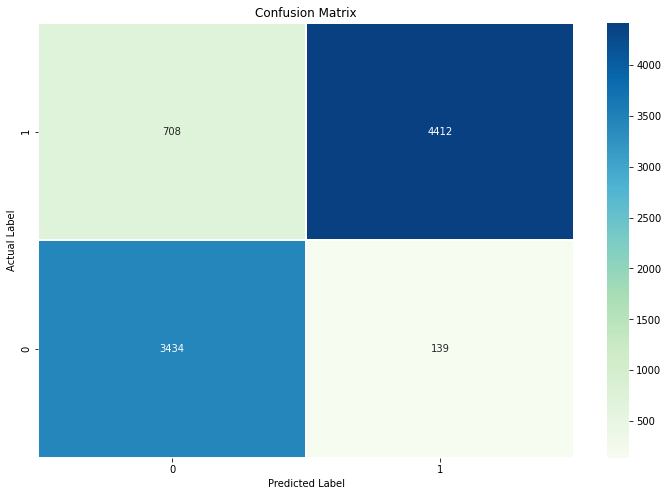

In [58]:
prediction = logreg_pipe.predict(X_test)

#Confusion Matrix
c_matrix = confusion_matrix(y_test, prediction)
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(c_matrix), annot=True, fmt='g',  cmap='GnBu', linewidths=1).set_ylim([0,2])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt. xlabel('Predicted Label');

#Evaluation Metrics
print('Accuracy', accuracy_score(y_test, prediction), '\n')
print('Classification Report:\n', classification_report(y_test, prediction, target_names=['User 2', 'User 1']))


In [59]:
#we can compare the accuracy on the test set with the training set
print('Test set accuracy:', logreg_pipe.score(X_test, y_test))
print('Training set accuracy:', logreg_pipe.score(X_train, y_train))

Test set accuracy: 0.9025652824111354
Training set accuracy: 0.917052546808939


On unseen data, our model was able to predict an output with an accuracy of 0.90. The confusion matrix shows that most of the errors occurred when the model predicted a 0 (User 2) when in fact, the song was in 1 (User 1)'s playlist. Nonetheless, an accurracy of 0.90 is quite good. We can still try and fine-tune it further. 

### Tuning the Model



Perhaps, the imbalance in datasets, where User 2 accounted for around 40% of the entire dataset, may have been the cause of the errors. We could try to balance out the data so that the sample sizes are the same. 

Through some research, sklearn's resample method could be worth trying out.
https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

In [44]:
#combine training X and y
train_df = pd.concat([X_train, y_train], axis=1)

print('Initial training size:', train_df.shape)

user_1_train = train_df[train_df['user_group'] == 1]
user_2_train = train_df[train_df['user_group'] == 0]

#upsample the minority class --> User 2 group
user_2_upsampled = resample(user_2_train,
                           replace=True,
                           n_samples=len(user_1_train),
                           random_state=2020)
#undersample the majority class --> user 1
user_1_undersampled = resample(user_1_train,
                              replace=True,
                              n_samples=len(user_2_train),
                              random_state=2020)

#create new dataset with resampled dataset
upsampled_train = pd.concat([user_1_train, user_2_upsampled], sort=False)
upsampled_train.head()

Initial training size: (34769, 25)


,track_id,artist_id,album_type,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,release_date_day,release_date_month,release_date_year,release_date_dayofweek,release_date_week,artist_genre,artist_follower_count,user_group
4912,4w7yrP4RAeeyhfG9nJqQvS,0c173mlxpT3dSFRgMO8XPh,album,5,0.823,0.733,1,-5.474,Major,0.0628,0.0349,0.00000,0.324,0.397,97.972,284387,4,23,2,2015,0,9,hip hop,7197345,1
2002,3cUfX4o0hLjcApgdWIHWkl,4zYX8Aa744hQ5O2hpAYQI3,single,19,0.636,0.909,3,-4.245,Minor,0.1200,0.0362,0.85700,0.109,0.181,149.969,195900,4,8,2,2016,0,6,electronic trap,35539,1
4513,5wUUWVRvrciJqFitZF8R0P,3TVXtAsR1Inumwj472S9r4,album,66,0.643,0.541,2,-5.801,Major,0.0426,0.0102,0.00000,0.102,0.165,119.499,311197,4,29,7,2014,1,31,toronto rap,45646939,1
2345,0ZGkJlkTO2tqn6nRC3PSFj,1vo8zHmO1KzkuU9Xxh6J7W,single,2,0.514,0.862,0,-6.329,Minor,0.1560,0.0319,0.17100,0.119,0.501,126.112,184762,4,2,12,2016,4,48,big room,197384,1
2929,7HdZY9UJTylIiNcSDFyUDc,738wLrAtLtCtFOLvQBXOXp,single,60,0.747,0.641,1,-4.502,Major,0.0925,0.2500,0.00107,0.106,0.453,100.028,186231,4,16,1,2018,1,3,tropical house,5986789,1


In [45]:
#check the resampled training size
print('Resampled training size:', upsampled_train.shape)

Resampled training size: (41002, 25)


In [46]:
#split the datasets and run it through the model
X_train_up = upsampled_train.drop('user_group', axis=1)
y_train_up = upsampled_train['user_group']

user_1_prevalence = calc_prevalence(y_train_up.values)
user_2_prevalence = 1 - user_1_prevalence 

print('Train Dataset:')
print('Prevalence of User 1 in train: ', round(user_1_prevalence * 100, 2), '%', sep='')
print('Prevalence of User 2 in train: ', round(user_2_prevalence * 100, 2), '%', sep='')

Train Dataset:
Prevalence of User 1 in train: 50.0%
Prevalence of User 2 in train: 50.0%


Now, our sample sizes are all equal.

In [60]:
#fit on the Logistic Regression pipeline 
logreg_pipe.fit(X_train_up, y_train_up)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['key'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'key', 'data_type': dtype('O'),
                                          'mapping': 1       1
3       2
8       3
2       4
9       5
4       6
0       7
6       8
5       9
11     10
7      11
10     12
NaN    -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=['track_id', 'artist_id', 'album_type',
                                     'mode'...
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
                                    dual=False, fit_intercept=True,
         

Accuracy 0.9023352122397331 

Classification Report:
               precision    recall  f1-score   support

      User 2       0.84      0.94      0.89      3573
      User 1       0.95      0.88      0.91      5120

    accuracy                           0.90      8693
   macro avg       0.90      0.91      0.90      8693
weighted avg       0.91      0.90      0.90      8693



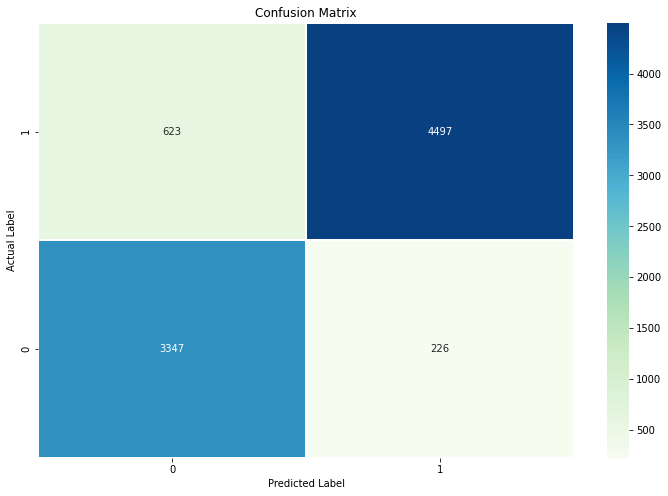

In [61]:
#Scoring:
prediction = logreg_pipe.predict(X_test)

#Confusion Matrix
c_matrix = confusion_matrix(y_test, prediction)
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(c_matrix), annot=True, fmt='g',  cmap='GnBu', linewidths=1).set_ylim([0,2])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt. xlabel('Predicted Label');

#Evaluation Metrics
print('Accuracy', accuracy_score(y_test, prediction), '\n')
print('Classification Report:\n', classification_report(y_test, prediction, target_names=['User 2', 'User 1']))

Looks like our score improved, but very slightly. 

#### Principle Component Analysis (PCA)
PCA is a method of dimensionality reduction often used to reduce the number of variables whilst keeping important features. We do this by setting a limit of how much explained variance should be visible in our data. As we're performing one-hot-encoding on the artist_name and artist genre, this would reduce the dimentions of our dataset before we run our estimator at the end of the pipeline. PCA is commonly considered a good way to decrease the chance of overfitting. 

We could try to incorporate PCA into the pipeline to further improve the accuracy of our model.

In [0]:
#initialize PCA with a 90% explained variance
pca = PCA(n_components=0.90)

#parse it into the pipeline
logreg_pipe_2 = make_pipeline(ore, ohe, sc, pca, LogisticRegression(C=0.001, 
    penalty='l2', class_weight='balanced', solver='liblinear'))

In [54]:
#fit the new pipeline on the upsampled training data - as it performed slightly better than the original pipeline
logreg_pipe_2.fit(X_train_up, y_train_up)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['key'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'key', 'data_type': dtype('O'),
                                          'mapping': 1       1
3       2
8       3
2       4
9       5
4       6
0       7
6       8
5       9
11     10
7      11
10     12
NaN    -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('onehotencoder',
                 OneHotEncoder(cols=['track_id', 'artist_id', 'album_type',
                                     'mode'...
                 PCA(copy=True, iterated_power='auto', n_components=0.9,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logisticregression',
                 LogisticRegression(C=0.001, class_weight='balanced',
          

Accuracy 0.9070516507534798 

Classification Report:
               precision    recall  f1-score   support

      User 2       0.86      0.93      0.89      3573
      User 1       0.95      0.89      0.92      5120

    accuracy                           0.91      8693
   macro avg       0.90      0.91      0.91      8693
weighted avg       0.91      0.91      0.91      8693



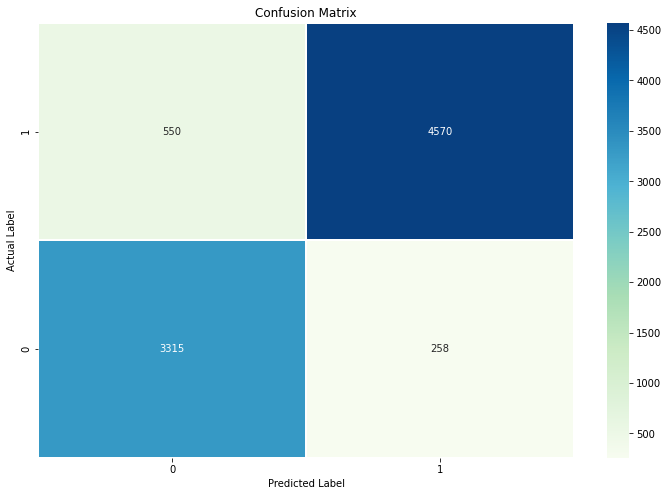

In [62]:
#Scoring:
prediction = logreg_pipe_2.predict(X_test)

#Confusion Matrix
c_matrix = confusion_matrix(y_test, prediction)
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(c_matrix), annot=True, fmt='g',  cmap='GnBu', linewidths=1).set_ylim([0,2])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt. xlabel('Predicted Label');

#Evaluation Metrics
print('Accuracy', accuracy_score(y_test, prediction), '\n')
print('Classification Report:\n', classification_report(y_test, prediction, target_names=['User 2', 'User 1']))

Our training our model on 90% explained variance resulted in a higher accuracy score with PCA. This suggests that reducing the dimentionality of the data helps. 

Although slightly, theres a decrease in the False Psitives; where the model predicted the track to be classified as 0 (User 2), when in fact, was 1 (User 1). 

If time permits, we could consider utilizing gridsearch to find the optimal PCA... maybe next time.

#### Evaluation 
Evaluating this model; we were able to produce an accuracy score of 0.907. The confusion matrix explains that User 1 had a higher probability of predicting True Positives, suggesting that the model was able to learn his/her music taste more precisely - a precision score of 0.95. 

With more time, we could have investigated other popular algorithms used for classification, such as Support Vector Machine and Nearest Neighbors. Another important insight to point out is that there were around 270 tracks that were in both playlists. This possibly influenced the dependent variable. We could have possibly tackled this by taking into consideration the common tracks - either dropping it from the data, or creating a new target variable to transform the algorithm into multi-classification.

### Pickle 
For now, let's pickle the pipeline to maintain reproducability. 

In [0]:
with open('spotify.pkl', 'wb') as file:
    pickle.dump(logreg_pipe_2, file)